In [1]:
import cv2
import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf 
import PIL

import os
from pathlib import Path
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model

Using TensorFlow backend.


In [7]:
import os
from pathlib import Path
from keras.preprocessing import image

input_path = Path("./Train")

dirs = input_path.glob("*")

image_data=[]
labels = []
image_path=[]

label_dict = {"Jerry":0,"Mohan":1,"Swagat":2}
label2alien={0:"Jerry",1:'Mohan',2:"Swagat"}


for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1]
    
    cnt = 0
    print(folder_dir)
    
    # Iterate over folder_dir and pick all images
    for img_path in folder_dir.glob("*.jpg"):
        
        img = image.load_img(img_path,target_size=(224,224))
        
        img_array = image.img_to_array(img)
        
        image_data.append(img_array)
    
        labels.append(label_dict[label])
        
        cnt+=1
        
    
print(cnt)

Train\Jerry
Train\Mohan
Train\Swagat
98


In [8]:
print(len(image_data))
print(len(labels))

294
294


In [9]:
X=np.array(image_data)
X=X/255.0

y=np.array(labels)

In [10]:
print(X.shape)
print(y.shape)

(294, 224, 224, 3)
(294,)


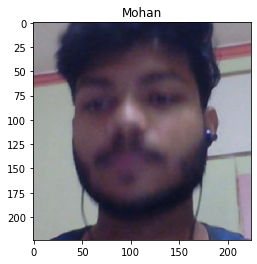

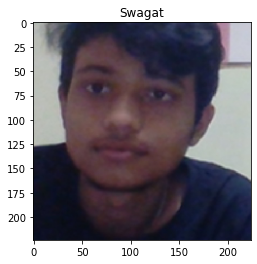

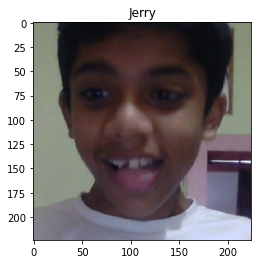

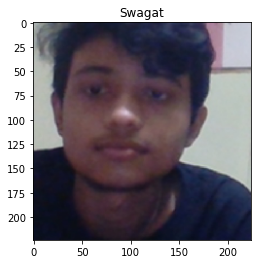

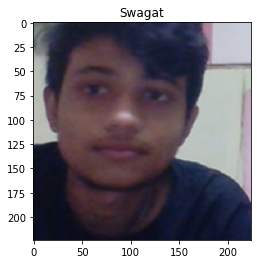

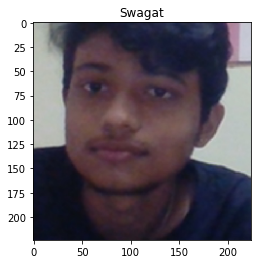

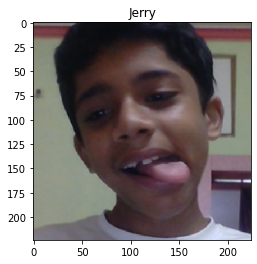

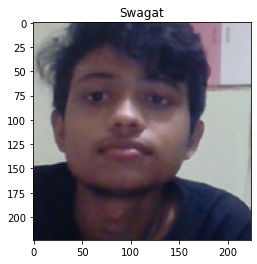

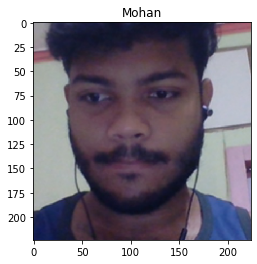

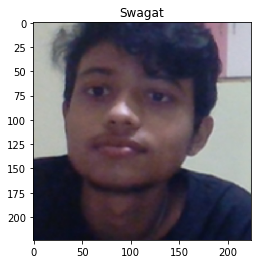

In [11]:
def drawImg(img,label):
    plt.title(label2alien[label])
    plt.imshow(img)
    plt.show()
    
for i in range(10):
    idx=np.random.randint(294)
    drawImg(X[idx],y[idx]) 

In [12]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [13]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(3, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)



# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:

# Use the Image Data Generator to import the images from the dataset

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('./Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('./Test',
                                            target_size = (224, 224),
                                            batch_size=58,
                                            class_mode = 'categorical')

Found 294 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [18]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=2,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/2
10/10 [==============================] - 78s 8s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1393 - val_accuracy: 0.9100
Epoch 2/2
10/10 [==============================] - 79s 8s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1563 - val_accuracy: 0.9367


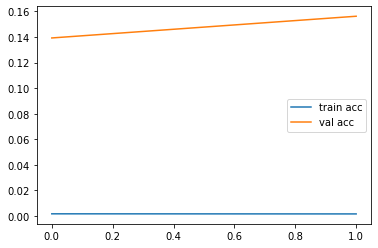

In [19]:
# accuracies
plt.plot(r.history['loss'], label='train acc')
plt.plot(r.history['val_loss'], label='val acc')
plt.legend()
plt.show()

In [20]:
from keras.models import load_model

model.save('model_vgg19.h5')

model = keras.models.load_model("model_vgg19.h5")


In [21]:
X_test,y_test = test_set.next()
y_test= np.argmax(y_test, axis=1)
len(y_test)

58

In [22]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
len(y_pred)

58

In [23]:
y_test

array([2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       2, 0, 0, 0, 2, 0, 1, 2, 1, 2, 0, 1, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0,
       0, 1, 2, 2, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [25]:
y_pred[0]

2

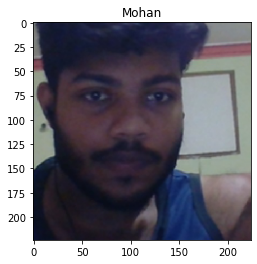

In [26]:
label2alien={0:'Jerry',1:'Mohan',2:"Swagat"}

def drawImg(img,label):
    plt.title(label2alien[label])
    plt.imshow(img)
    plt.show()

num = 1
drawImg(X_test[num],y_pred[num]) 

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print('CONFUSION MATRIX :\n ',cm)
print('accuracy :\n',accuracy_score(y_test, y_pred)) 

CONFUSION MATRIX :
  [[16  7  0]
 [ 0 16  1]
 [ 0  0 18]]
accuracy :
 0.8620689655172413
